In [23]:
from scipy.optimize import minimize
import numpy as np
from scipy import stats
import multiprocessing as mp
import shelve
import matplotlib.pyplot as plt
import matplotlib as mpl

from helper import get_predator_prey_data, mse_trunc, \
    remove_data_points_rand, remove_data_points_det, int_cost_lotka_volterra
from workers import vary_truncation_worker

In [24]:
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 11
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"""
\usepackage{palatino}
\usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [2]:
def get_n_removed_points(d):
    return len(np.argwhere(d.flatten() == -1))

def trunc_cost(*args):
    return int_cost_lotka_volterra(*args, cost=mse_trunc)

def generate_truncated_datasets(P, n, max_points, col):
    p = P.copy()
    Ps = [p]
    for i in range(max_points//n):
        p = remove_data_points_det(p.copy(), n, col=col)
        Ps.append(p)
    return Ps

In [7]:
def vary_truncation(trunc_datasets, P, t, rv, n_sim=100, T_start=200, T_steps=2000):
    manager = mp.Manager()
    results = manager.list()

    work_queue = mp.Queue()
    for i in range(len(trunc_datasets)):
        results.append(manager.list())
        for j in range(n_sim):
            work_queue.put((i, j))

    processes = []

    for i in range(mp.cpu_count()):
        p = mp.Process(target=vary_truncation_worker, args=(
            work_queue, results, T_start, T_steps, P, t, rv, trunc_datasets
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return [list(t) for t in results], trunc_datasets

In [13]:
%%time
if False:
    with shelve.open("Arrays/data_removal") as shelf:
        n = 10           # number of points to remove every time
        max_points = 100 # max number of points to remove. if not divisible by n, will floor down
        n_sim = 100

        t, P = get_predator_prey_data()

        np.random.seed(74545)
        
        # truncate x timeseries
        trunc_datasets_x = generate_truncated_datasets(P, n, max_points, 0)
        print([get_n_removed_points(p) for p in trunc_datasets_x])
        rv = [1, 1, 0.2, 1]

        costs_x, datasets_x = vary_truncation(trunc_datasets_x, P, t, rv, n_sim=n_sim)
        shelf["data_removal_costs_x"] = costs_x
        shelf["datasets_x"] = datasets_x

        # truncate y timeseries
        trunc_datasets_y = generate_truncated_datasets(P, n, max_points, 1)
        print([get_n_removed_points(p) for p in trunc_datasets_y])

        costs_y, datasets_y = vary_truncation(trunc_datasets_y, P, t, rv, n_sim=n_sim)
        shelf["data_removal_costs_y"] = costs_y
        shelf["datasets_y"] = datasets_y

        shelf.close()

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


/home/soud/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/soud/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


/home/soud/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/soud/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/soud/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1867352139417D+02   r2 =  0.1608987821401D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1867352139417D+02   r2 =  0.1608987821401D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1867352139417D+02   r2 =  0.1608987821401D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1867352139417D+02   r2 =  0.1608987821401D-14
 lsoda--  warning..internal t (=r1) 

      in above,  r1 =  0.1334818139954D+02   r2 =  0.6800960239319D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1334818139954D+02   r2 =  0.6800960239319D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1334818139954D+02   r2 =  0.6800960239319D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1334818139954D+02   r2 =  0.5442526127051D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.13348181399

      in above,  r1 =  0.1394000430175D+02   r2 =  0.6942076244519D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1394000430175D+02   r2 =  0.5747918263316D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1394000430175D+02   r2 =  0.5747918263316D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1394000430175D+02   r2 =  0.5747918263316D-15
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  warning..internal t (=r1) and h (=r2) are  
    

In [28]:
#Open data
shelf = shelve.open("Arrays/data_removal")
costs_x = shelf["data_removal_costs_x"] 
datasets_x = shelf["datasets_x"]

costs_y = shelf["data_removal_costs_y"] 
datasets_y = shelf["datasets_y"] 
shelf.close() 

In [29]:
np.mean(costs_x, axis=1)

array([3.44688187e+00, 3.88709146e+00, 3.47112552e+00, 4.20541181e+00,
       3.62652587e+00, 4.90331009e+00, 1.26974929e+01, 4.61170217e+01,
       1.36122992e+01, 1.69377251e+02, 5.06443485e+05])

In [30]:
np.mean(costs_y, axis=1)

array([3.44688187e+00, 4.45877465e+00, 4.66814621e+00, 5.07688684e+00,
       4.18443103e+00, 3.30096846e+00, 4.21022290e+00, 4.87482892e+00,
       1.86920672e+08, 2.11309989e+02, 6.24631554e+01])

In [31]:
def sp_confidence_interval(samples, p=0.95):
    """ Calculates the confidence interval (with p=95% unless noted otherwise) 
    Returns:
         Confidence radius (int) based on samples.     
    """
    a = stats.t.interval(p, df=len(samples)-1, loc=np.mean(samples), scale=stats.sem(samples))
    return a[1] - a[0]

[3.44688187e+00 3.88709146e+00 3.47112552e+00 4.20541181e+00
 3.62652587e+00 4.90331009e+00 1.26974929e+01 4.61170217e+01
 1.36122992e+01 1.69377251e+02 5.06443485e+05]
[3.44688187e+00 4.45877465e+00 4.66814621e+00 5.07688684e+00
 4.18443103e+00 3.30096846e+00 4.21022290e+00 4.87482892e+00
 1.86920672e+08 2.11309989e+02 6.24631554e+01]


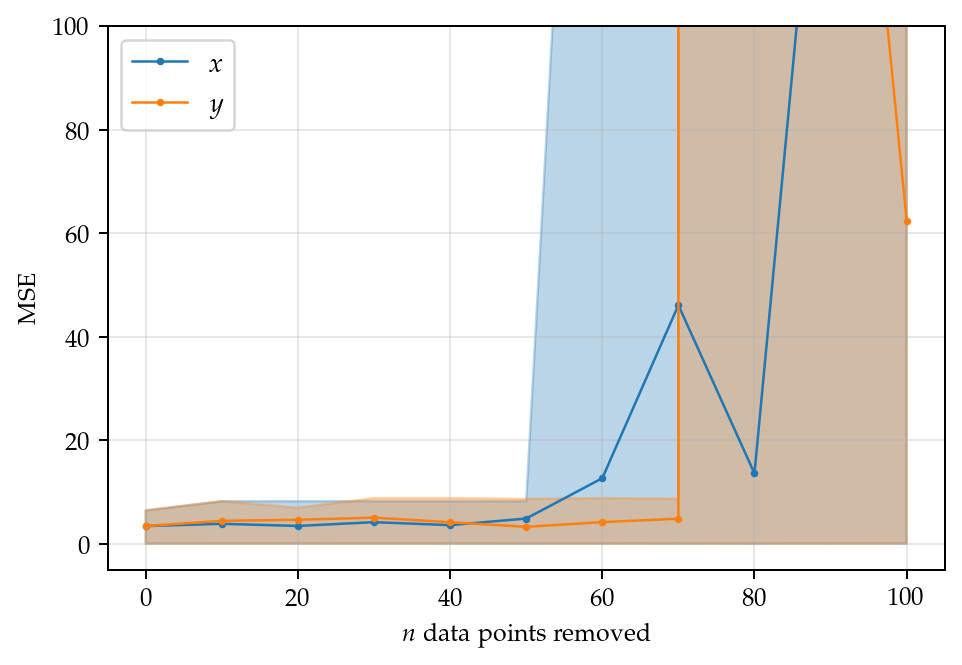

In [44]:
datasets = [datasets_x, datasets_y]
costs = [costs_x, costs_y]
colors = ["tab:blue", "tab:orange"]
for i in range(len(datasets)):
    mean = np.mean(costs[i], axis = 1)
    print(mean)
    min_ = np.min(costs[i], axis = 1)
    max_ = np.max(costs[i], axis = 1)
    x = [get_n_removed_points(p) for p in datasets[i]]
    a = [sp_confidence_interval(samples) for samples in np.array(costs[i])]
    plt.plot(x, mean, marker="o", markersize = 2, linewidth=1, color = colors[i], label=f"{['$x$', '$y$'][i]}")
    plt.fill_between(x, min_, max_, alpha=0.3, color = colors[i])
    #plt.errorbar(x, mean, yerr=a, color = colors[i], capsize = 1, elinewidth=0.5, markeredgewidth=1)
plt.grid(alpha=0.3)
plt.ylabel("MSE")
plt.ylim(-5, 100)
plt.xlabel("$n$ data points removed")
plt.legend()
plt.show()